# Notebook for PCA development

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm

from dpet.analysis import EnsembleAnalysis
from dpet.logger import stream as st

# Load data

In [2]:
# Codes.
ens_codes = [
    "3a1g_B_prod_R1_fit",
    "3a1g_B_prod_R2_fit",
    "3a1g_B_prod_R3_fit"
]

# Instantiate the pipeline object.
pipeline = EnsembleAnalysis()

# Load some data.
data_dp = "/home/giacomo/projects/ensemble_analysis/git/EnsembleTools/ensemble_files/3a1g_B"
pipeline.load_ensembles(
    input_dp=data_dp,
    codes=ens_codes,
    format="traj",
    topology_fp=os.path.join(data_dp, "3a1g_B.pdb"),  # Not needed when format="pdb".
    ext="xtc"
)

st.write("Loaded ensembles with the following codes:", pipeline.codes)

Loading data for 3a1g_B_prod_R1_fit.
Found 200 conformations.
Loading data for 3a1g_B_prod_R2_fit.
Found 200 conformations.
Loading data for 3a1g_B_prod_R3_fit.
Found 200 conformations.
Loaded ensembles with the following codes: ['3a1g_B_prod_R1_fit', '3a1g_B_prod_R2_fit', '3a1g_B_prod_R3_fit']


# Featurization

In [3]:
# Featurization options.
# featurization = "phi_psi"
# featurization_params = {}

featurization = "ca_dist"
featurization_params = {"seq_sep": 2, "normalize": False}

pipeline.featurize(featurization=featurization,
                   params=featurization_params)

Featurizing the 3a1g_B_prod_R1_fit ensemble.
Featurized ensemble shape: (200, 741)
Featurizing the 3a1g_B_prod_R2_fit ensemble.
Featurized ensemble shape: (200, 741)
Featurizing the 3a1g_B_prod_R3_fit ensemble.
Featurized ensemble shape: (200, 741)


# Dimensionality reduction

In [4]:
reduce_dim_method = "pca"
reduce_dim_params = {}

reduce_dim = pipeline.dimensionality_reduction(
    method=reduce_dim_method,
    params=reduce_dim_params,
    fit_on=["3a1g_B_prod_R1_fit"]  # Fit PCA only on the first ensemble.
)

Performing dimensionality reduction on ca_dist data.
Input featurized ensemble shape: (200, 741)
Fitting...
Transforming 3a1g_B_prod_R1_fit.
Reduced dimensionality ensemble shape: (200, 10)
Transforming 3a1g_B_prod_R2_fit.
Reduced dimensionality ensemble shape: (200, 10)
Transforming 3a1g_B_prod_R3_fit.
Reduced dimensionality ensemble shape: (200, 10)


## PCA Analysis

- Percentage of variance explained by each of the selected components:


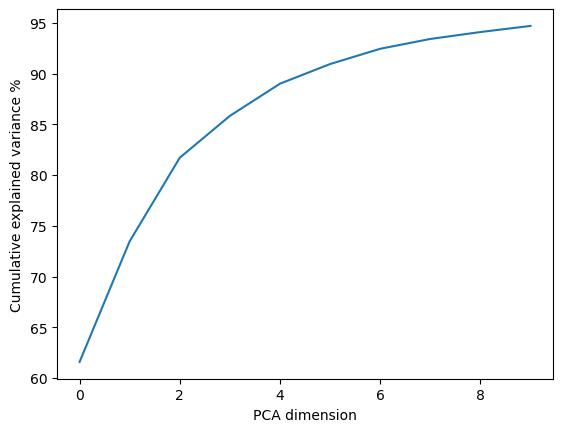

- First three components: 81.71082735061646


In [5]:
# Specific to PCA. In my opinion, useful PCAs should have at least
# a total of > 50% in the first 3 components.
print("- Percentage of variance explained by each of the selected components:")
plt.plot(np.cumsum(reduce_dim.model.explained_variance_ratio_)*100)
plt.xlabel("PCA dimension")
plt.ylabel("Cumulative explained variance %")
plt.show()
print("- First three components:", reduce_dim.model.explained_variance_ratio_[0:3].sum()*100)

### Plot 2d landscapes

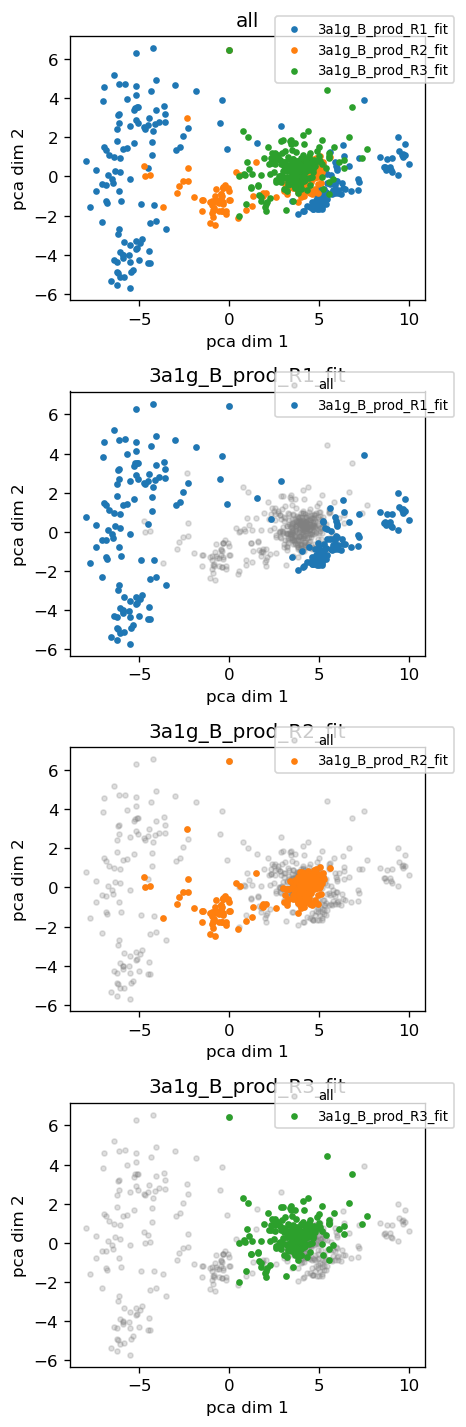

In [6]:
def set_labels(ax):
    ax.set_xlabel(f"{reduce_dim_method} dim {dim_x+1}")
    ax.set_ylabel(f"{reduce_dim_method} dim {dim_y+1}")

# 2d scatters.
dim_x = 0
dim_y = 1
marker = "."
legend_kwargs = {"loc": 'upper right',
                 "bbox_to_anchor": (1.1, 1.1),
                 "fontsize": 8}

# Plot all ensembles at the same time.
fig, ax = plt.subplots(len(ens_codes)+1, figsize=(4, 4*len(ens_codes)), dpi=120)
ax[0].set_title("all")
for code_i in pipeline.codes:
    ax[0].scatter(reduce_dim.data[code_i][:,dim_x],
                  reduce_dim.data[code_i][:,dim_y],
                  label=code_i, marker=marker)
ax[0].legend(**legend_kwargs)
set_labels(ax[0])

# Plot each ensembles.
for i, code_i in enumerate(pipeline.codes):
    ax[i+1].set_title(code_i)
    ax[i+1].scatter(reduce_dim.concat_data[:,dim_x],
                    reduce_dim.concat_data[:,dim_y],
                    label="all", color="gray", alpha=0.25,
                    marker=marker)
    ax[i+1].scatter(reduce_dim.data[code_i][:,dim_x],
                    reduce_dim.data[code_i][:,dim_y],
                    label=code_i, c=f"C{i}",
                    marker=marker)
    ax[i+1].legend(**legend_kwargs)
    set_labels(ax[i+1])

plt.tight_layout()
# plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA' + featurization+ ens_codes[0])
plt.show()


### 1d histograms

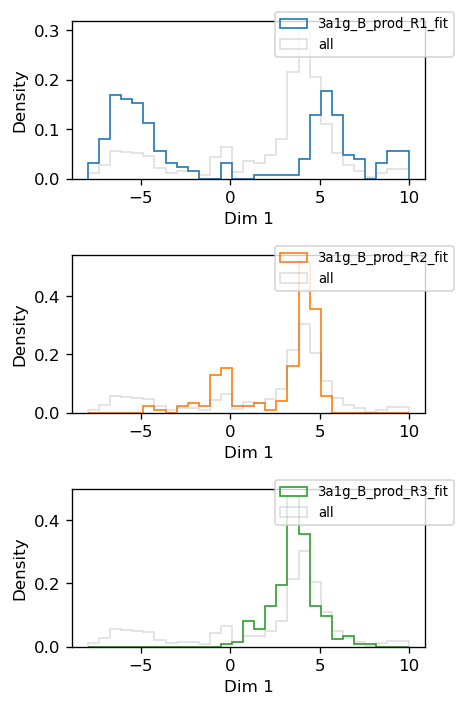

In [7]:
# 1d histograms. Looking at the scatter plot above can be misleading
# to the eye if we want to assess the density of points. Better use
# an histogram for a precise evaluation.
n_bins = 30

dpi = 120
fig, ax = plt.subplots(len(ens_codes), 1, figsize=(4, 2*len(ens_codes)), dpi=dpi)
k = 0
bins = np.linspace(reduce_dim.concat_data[:,k].min(),
                   reduce_dim.concat_data[:,k].max(),
                   n_bins)

for i, code_i in enumerate(ens_codes):
    ax[i].hist(reduce_dim.data[code_i][:,k],
               label=code_i,
               bins=bins,
               density=True,
               color=f"C{i}",
               histtype="step")
    ax[i].hist(reduce_dim.concat_data[:,k],
               label="all",
               bins=bins,
               density=True,
               color="gray",
               alpha=0.25,
               histtype="step")
    ax[i].legend(loc='upper right',
                 bbox_to_anchor=(1.1, 1.1),
                 fontsize=8
                )
    ax[i].set_xlabel(f"Dim {k+1}")
    ax[i].set_ylabel("Density")

plt.tight_layout()
# plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA_hist' + featurization+ ens_codes[0])
plt.show()

# Is PC 1 from Ca-Ca correlated with Rg? For fully intrinsically disordered proteins, this is what happens

An hallmark of fully-disordered ensembles at a global level is the following: when you do PCA with Ca-Ca distances, typically PC dimension 1 is strongly correlated with Rg, it describes changes in chain compactness. This is what happens in Sic1 ensembles too. 

Calculating rg for 3a1g_B_prod_R1_fit.
Calculating rg for 3a1g_B_prod_R2_fit.
Calculating rg for 3a1g_B_prod_R3_fit.


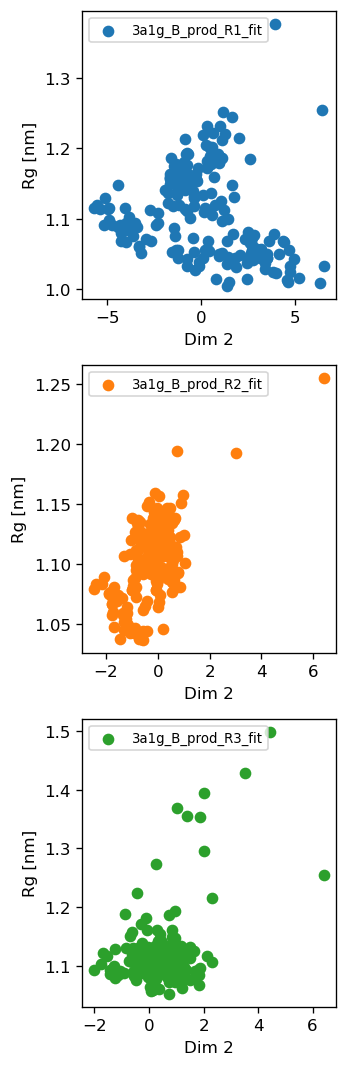

In [8]:
dpi = 120
fig, ax = plt.subplots(len(ens_codes), 1, figsize=(3, 3*len(ens_codes)), dpi=dpi)
pca_dim = 1

rg_data = pipeline.get_rg(codes="all")

for i, code_i in enumerate(ens_codes):
    ax[i].scatter(
        reduce_dim.data[code_i][:,pca_dim],
        rg_data[code_i], label=code_i,
        color=f"C{i}"
    )
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel(f"Dim {pca_dim+1}")
    ax[i].set_ylabel("Rg [nm]")

plt.tight_layout()
# plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA_RG' + ens_codes[0])
plt.show()